In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [4]:
# Load results of the fitting procedure

subject = 1
volume_space=True

fitting_type = 'gabor_solo_ridge_12ori_8sf_plus_texture_pyramid_ridge_4ori_4sf_pca_HL'

out = load_fits.load_fit_results(subject, fitting_type, n_from_end=0, verbose=True);
# load_fits.print_output_summary(out)
fig_save_folder=None
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf_plus_texture_pyramid_ridge_4ori_4sf_pca_HL/Feb-05-2022_2100_35/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'use_pca_pyr_feats_hl', 'pyramid_feature_info', 'group_all_hl_feats', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn'])


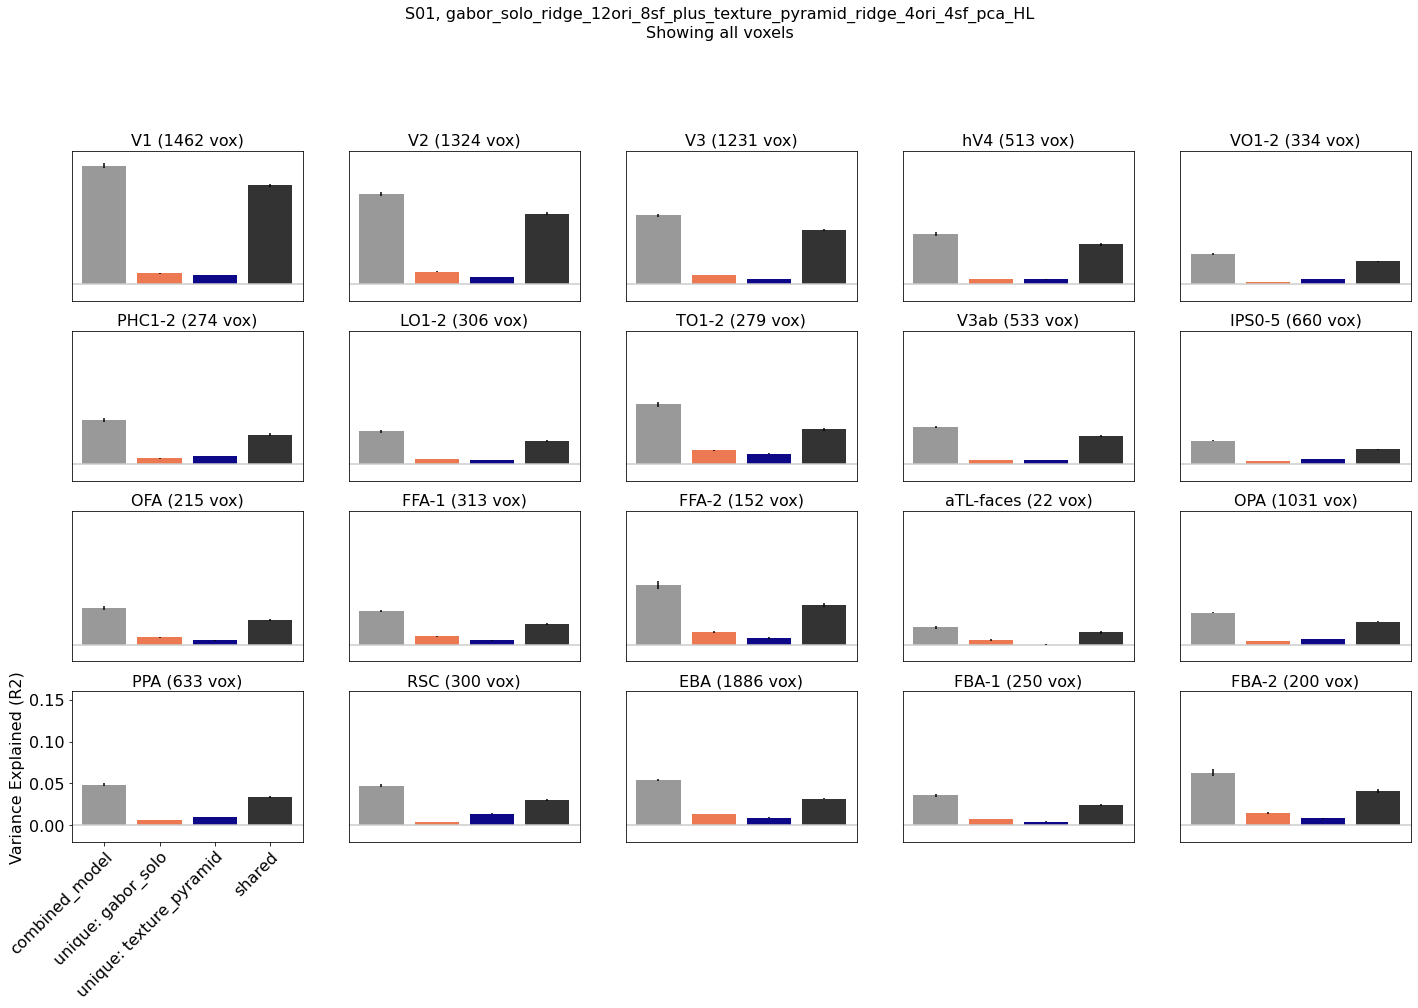

In [17]:
pp0 = 0
pp1 = 1
pp2 = 2
plot_utils.set_all_font_sizes(fs = 16)

val_r2 = out['val_r2']

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.16])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)


['just_texture_pyramid'
 'texture_pyramid_just_higher-level_plus_other_modules'
 'texture_pyramid_just_lower-level_plus_other_modules']
[641, 688, 145]
[96, 49, 592]


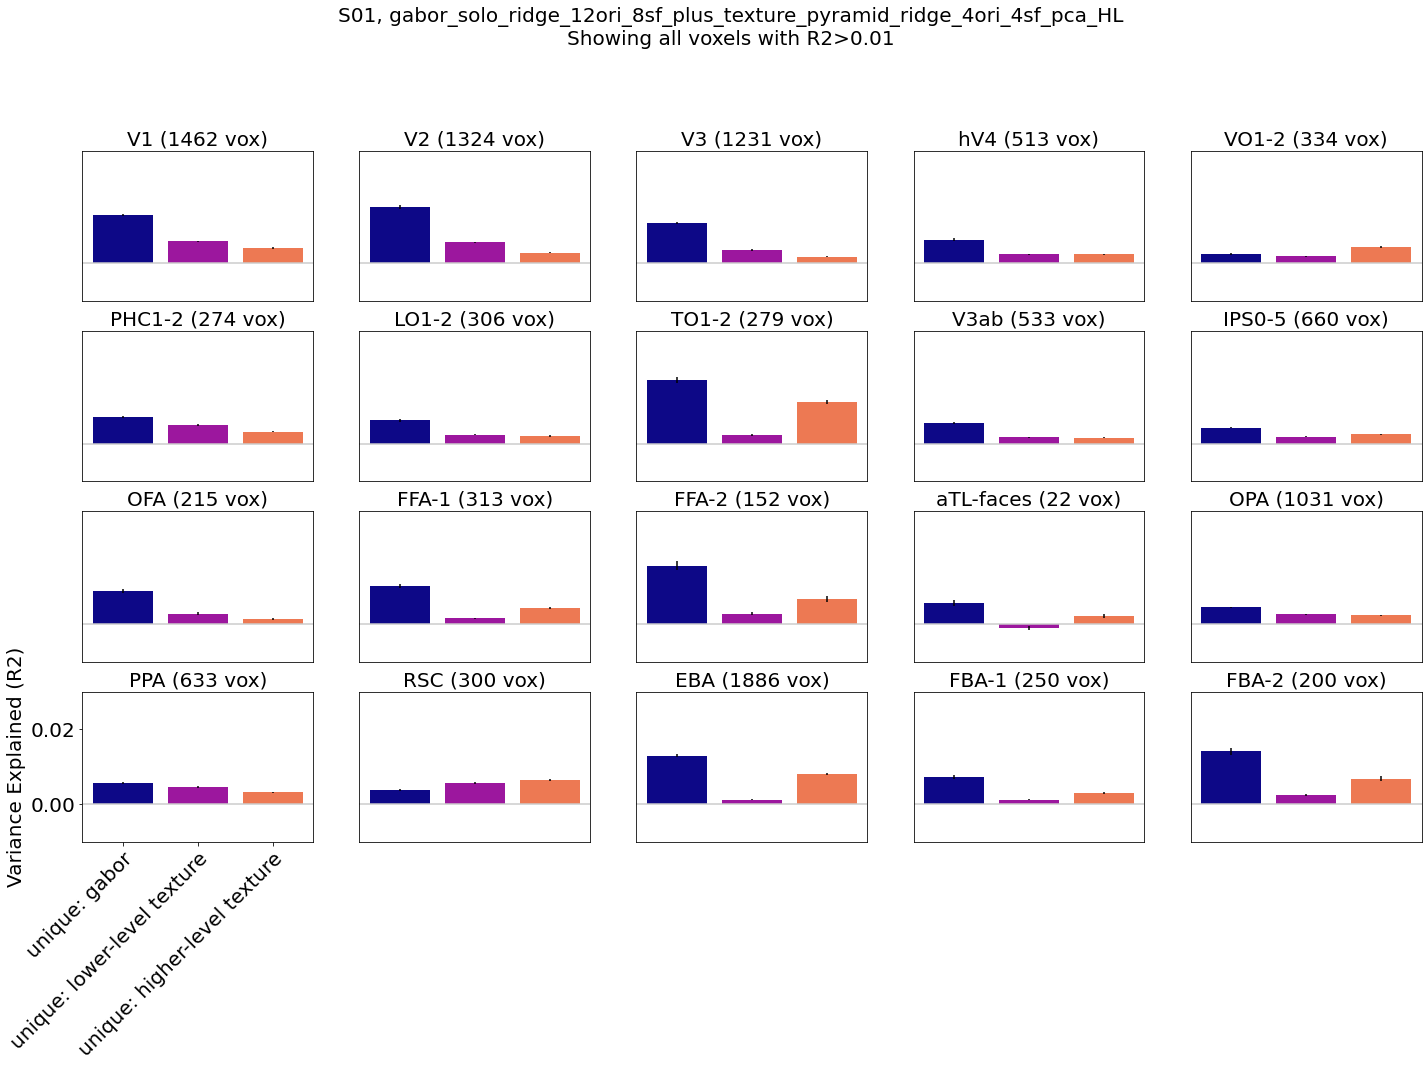

In [7]:

# each of these indices is one feature set left out at a time.
ppinds = [2,6,5]
print(np.array(out['partial_version_names'])[ppinds])
print([np.sum(out['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: lower-level texture', 'unique: higher-level texture']
var_expl = np.tile(out['val_r2'][:,0:1], [1,3]) - out['val_r2'][:,ppinds]

colors = cm.plasma(np.linspace(0,1,4))
# colors = np.flipud(colors)

r2_thresh = 0.01
inds2use = out['val_r2'][:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.03])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels with R2>%.2f'%(subject, fitting_type, r2_thresh))
plt.gcf().subplots_adjust(bottom=0.4)
